In [47]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [48]:
BATCH_SIZE = 32      # batches of 32
IMAGE_SIZE = 256     # 256 X 256 aspect ratio    
CHANNELS=3          # no. RGB channels
EPOCHS=50

In [49]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 4500 files belonging to 3 classes.


In [50]:
class_names = dataset.class_names
class_names                   # each class is a folder

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [51]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 2 2 2 0 2 1 2 2 2 2 1 1 2 1 1 1 0 1 1 0 0 1 0 1 1 2 0 1 1 1]


In [52]:
# Exploration

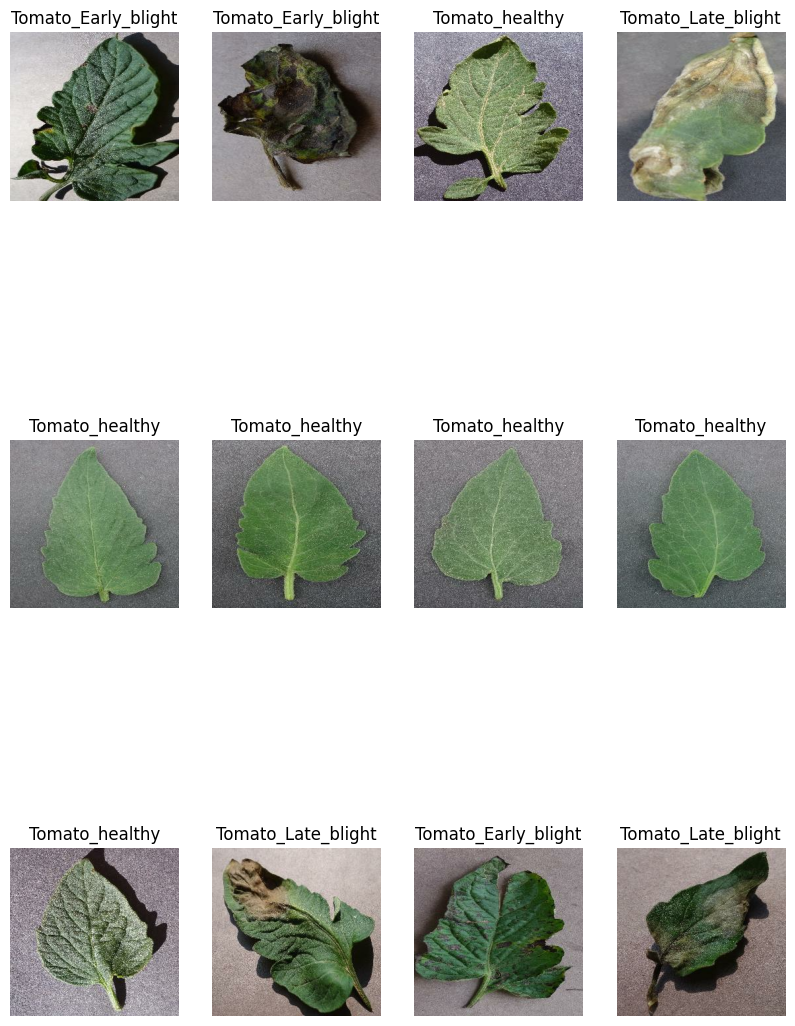

In [53]:
plt.figure(figsize=(10, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])         # display title
        plt.axis("off")                             # different output cuz shuffle="true"

In [54]:
len(dataset)


141

In [55]:
train_size=0.8         # train = 80% , Validation = 10%  Test = 10%
# validation after each epoch

In [56]:
train_ds = dataset.take(54)   # taking first 54 samples
len(train_ds)

54

In [57]:
test_ds=dataset.skip(54)
len(test_ds)

87

In [58]:
val_size = 0.1  # 10% of dataset
len(dataset)*val_size

14.100000000000001

In [59]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [60]:
test_ds = test_ds.skip(6)
len(test_ds)

81

In [61]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split+test_split +val_split)== 1
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=8)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)    # taking remaining validation
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [62]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [63]:
len(train_ds)


112

In [64]:
len(val_ds)


14

In [65]:
len(test_ds)


15

In [66]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
                                                 
# Prefetch and catching for  optimizing performance                                                 

In [67]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [68]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),  # agumenting images in diff angles and filters, to create larger dataset
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [69]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [72]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),            # 64 neurons
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [73]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [74]:
# Compiling the model

In [75]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [76]:
history = model.fit(            # training network
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
112/112 [==============================] - 387s 3s/step - loss: 0.9835 - accuracy: 0.4824 - val_loss: 0.9603 - val_accuracy: 0.4978
Epoch 2/15
112/112 [==============================] - 337s 3s/step - loss: 0.7562 - accuracy: 0.6106 - val_loss: 0.7266 - val_accuracy: 0.6473
Epoch 3/15
112/112 [==============================] - 338s 3s/step - loss: 0.5602 - accuracy: 0.7450 - val_loss: 0.4316 - val_accuracy: 0.8259
Epoch 4/15
112/112 [==============================] - 342s 3s/step - loss: 0.4534 - accuracy: 0.8082 - val_loss: 0.8449 - val_accuracy: 0.7388
Epoch 5/15
112/112 [==============================] - 306s 3s/step - loss: 0.3332 - accuracy: 0.8603 - val_loss: 0.3571 - val_accuracy: 0.8504
Epoch 6/15
112/112 [==============================] - 311s 3s/step - loss: 0.3048 - accuracy: 0.8765 - val_loss: 0.5198 - val_accuracy: 0.7946
Epoch 7/15
112/112 [==============================] - 305s 3s/step - loss: 0.2816 - accuracy: 0.8905 - val_loss: 0.5570 - val_accuracy: 0.7857

In [77]:
scores = model.evaluate(test_ds)

15/15 [==============================] - 22s 704ms/step - loss: 0.4031 - accuracy: 0.8625


In [78]:
scores

[0.4030715525150299, 0.862500011920929]

In [79]:
history

In [80]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 112}

In [81]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [82]:
type(history.history['loss'])


list

In [83]:
len(history.history['loss'])


15

In [84]:
history.history['loss'][:5] # loss for the first 5 epochs


[0.9834738373756409,
 0.7561513781547546,
 0.5602025985717773,
 0.45335903763771057,
 0.33324965834617615]

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Tomato_healthy
1/1 [==============================] - 1s 864ms/step
predicted label: Tomato_healthy


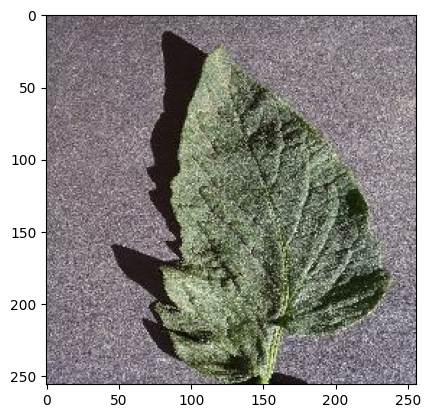

In [86]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [87]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 67ms/step


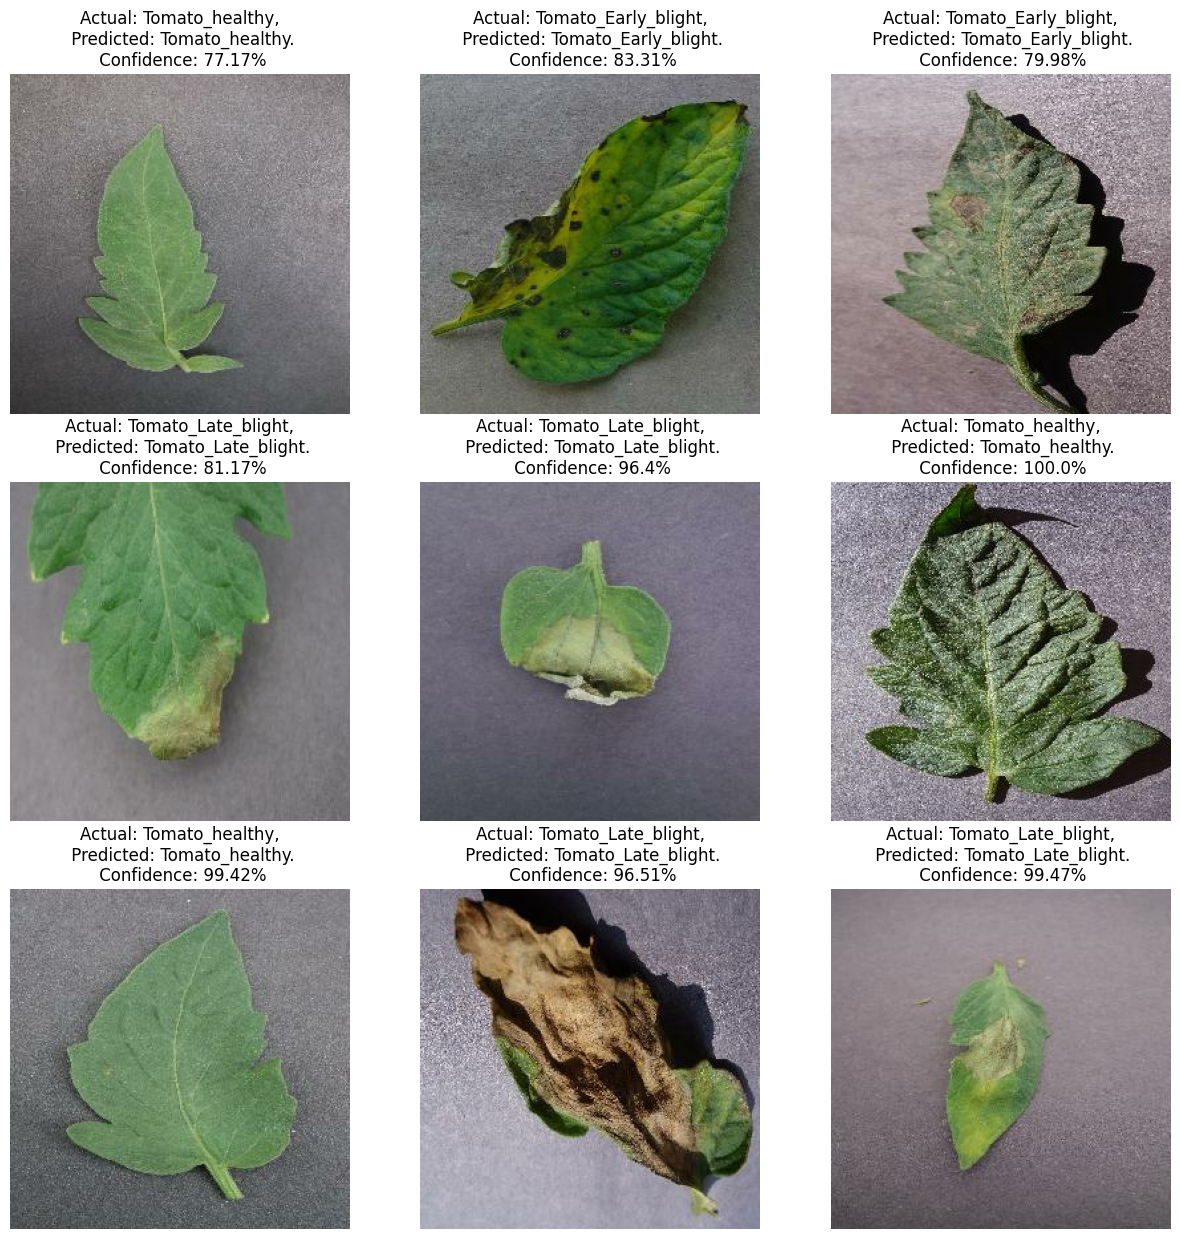

In [88]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")